# **Projeto Visão Computacional - Classificação de Imagens**

### **Preparando o ambiente**

In [1]:
import os

import numpy as np

from skimage import transform, measure, util, color, filters, morphology
from sklearn import model_selection, neighbors, metrics, preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#%matplotlib notebook

### **Parâmetros para reprodutibilidade**

In [2]:
random_state=393
np.random.seed(random_state)

### **Preparando o conjunto de dados**

In [3]:
# Define o caminho para o conjunto de dados completo
ds_path = 'data/mpeg7_4classes_aug_x8_work'

# Define o caminho para o conjunto de treino
train_path = ds_path + '/Train'

# Define uma lista com os nomes das classes
classes_list = os.listdir(train_path)

print(f'Classes: {classes_list}')

# Lista com as imagens no dataset de treino
train_image_list = []

# Lista com os rótulos das imagens no dataset de treino
train_label_list = []

# Lista com os nomes das imagens
train_filename_list = []

# Percorre as classes do dataset
for classe in classes_list:

    # Listagem de todas as imagens na pasta daquela classe
    filename_list_tmp = os.listdir(os.path.join(train_path, classe))

    for filename in filename_list_tmp:

        # Carrega a imagem
        img_tmp = plt.imread(os.path.join(train_path, classe, filename))
        
        # Redimensiona a imagem para 164 x 164 pixels
        img_tmp = transform.resize(img_tmp, (164, 164), anti_aliasing=True)
        
        # Adiciona a imagem a lista de imagens
        train_image_list.append(img_tmp)
        
        # Adiciona o rótulo da imagem à lista de rótulos
        train_label_list.append(classe)
        
        # Adiciona o nome da imagem à uma lista (para fins de visualização)
        train_filename_list.append(filename)

# Conversão dos nomes das classes para índices numéricos
_, _, label_list_train_idx = np.unique(train_label_list, return_index=True, return_inverse=True)

Classes: ['apple', 'bat', 'beetle', 'bone']


### **Plotando as imagens**

In [4]:
image_list_temp = []
filename_list_temp = []

# Seleciona 6 imagens de cada uma das 4 classes
for i in range(4):
    image_list_temp += [train_image_list[j] for j in np.where(label_list_train_idx==i)[0][:6]]
    filename_list_temp += [train_filename_list[j] for j in np.where(label_list_train_idx==i)[0][:6]]

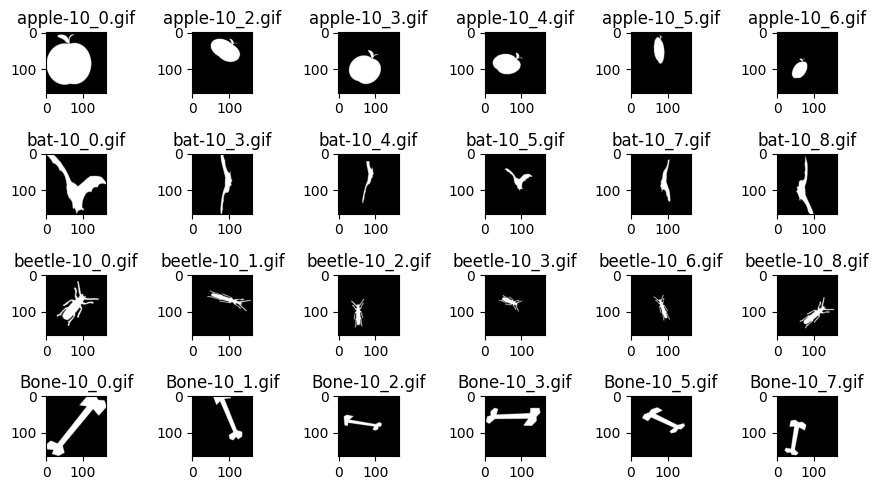

In [5]:
fig, ax  = plt.subplots(4, 6, figsize=(9, 5))

for i, (image, filename) in enumerate(zip(image_list_temp, filename_list_temp)):
    ax[i//6, i%6].imshow(image, cmap='gray')
    ax[i//6, i%6].set_title(str(filename))

fig.tight_layout()
plt.show()

### **Extração de características**

In [6]:
# Características que serão extraídas
features = ['area', 'area_convex', 'extent', 'major_axis', 'minor_axis', 'solidity']

In [7]:
def FeatureXtract(img_list, lbl_list):
    
    # Matriz que irá armazenar as características das imagens
    feature_mat = []
    
    # Lista que irá armazenar as novas imagens
    new_img_list = []
    
    # Lista que irá armazenar os rótulos das imagens
    list_label = []

    for i, (image, label) in enumerate(zip(img_list, lbl_list)):

        # Adiciona o rótulos (label) da imagem à lista
        list_label.append(label)

        # Remove objetos na imagem com menos de N pixels
        new_image = morphology.remove_small_objects(image.astype(bool), 80)

        # Adiciona a imagem modificada à lista
        new_img_list.append(new_image)

        # Calcula a imagem de rótulos
        img_label = measure.label(new_image)

        # Calcula uma lista de propriedades (caracteristicas) dos objetos na imagem
        props = measure.regionprops(img_label)
        
        if len(props) != 1:
            print(f'ERRO de segmentação: {len(props)}')
            continue

        # Itera pelas propriedades computadas
        for prop in props:

            # Prop. 0: Area
            area = prop.area

            # Prop. 1: Area Convexa
            area_convex = prop.area_convex

            # Prop. 2: Extensão
            extent = prop.extent

            # Prop. 3: Maior eixo
            major_axis = prop.major_axis_length

            # Prop. 4: Menor eixo
            minor_axis = prop.minor_axis_length 

            # Prop. 5: Solidez
            solidity = prop.solidity

            # Monta o vetor de caracteristicas deste objeto
            feature_list = [area, area_convex, extent, major_axis, minor_axis, solidity]

        # Adiciona as caracteristicas desta imagem na matriz de caracteristicas
        feature_mat.append(feature_list)
    
    # Retorna a matriz de características
    return feature_mat

In [8]:
# Realiza a extração de características no conjunto de treino
train_feature_mat = FeatureXtract(train_image_list, train_label_list)

In [9]:
# Converte a lista de caracteristicas para um arranjo NumPy
train_feature_map = np.array(train_feature_mat)

# Imprime a matriz de caracteristica
with np.printoptions(precision=4, suppress=True):
    print(train_feature_map)

[[63229.     87965.         0.5877   178.9349     5.0933     0.7188]
 [38272.     69056.         0.3557   194.7404     4.2941     0.5542]
 [43783.     74251.         0.407    181.5218     4.8066     0.5897]
 ...
 [34183.     74388.         0.3177   216.1122     3.9153     0.4595]
 [35401.     76191.         0.3291   207.6742     4.0457     0.4646]
 [33649.     74075.         0.3128   206.6875     3.7837     0.4543]]


### **Plotando as caracteristicas computadas**

In [10]:
df = pd.DataFrame(train_feature_map, columns=features)

df['class'] = train_label_list

display(df)

,area,area_convex,extent,major_axis,minor_axis,solidity,class
0,63229.0,87965.0,0.587718,178.934892,5.093317,0.718797,apple
1,38272.0,69056.0,0.355741,194.740372,4.294103,0.554217,apple
2,43783.0,74251.0,0.406966,181.521821,4.806602,0.589662,apple
3,37417.0,68339.0,0.347793,190.915751,4.360461,0.547520,apple
4,32146.0,63673.0,0.298799,204.889328,3.500406,0.504861,apple
...,...,...,...,...,...,...,...
499,30814.0,65805.0,0.286418,202.536358,3.237239,0.468262,bone
500,34783.0,77214.0,0.323310,214.846559,4.105609,0.450475,bone
501,34183.0,74388.0,0.317733,216.112204,3.915278,0.459523,bone
502,35401.0,76191.0,0.329055,207.674163,4.045704,0.464635,bone


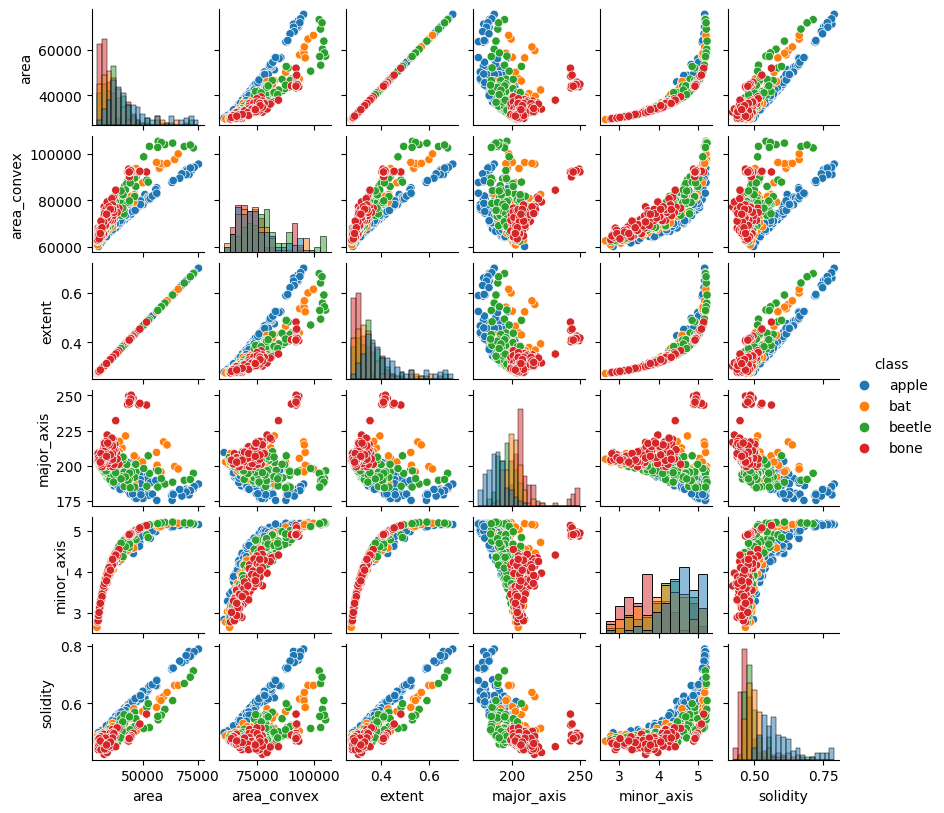

In [11]:
g = sns.PairGrid(df, hue='class', vars=features)
g.fig.set_size_inches(8, 8)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

### **Validação cruzada (Hold-out)**

In [12]:
# Separa o conjunto de dados em 'train_feature_map', de acordo com 'train_label_list'. 
# 30% das imagens vão para o conjunto de validação.
X_train, X_val, y_train, y_val = model_selection.train_test_split(train_feature_map, 
                                                                  train_label_list, 
                                                                  test_size=0.3,
                                                                  stratify=train_label_list,
                                                                  random_state=random_state)

### **Normalização das características do novo conjunto de treinamento**

In [13]:
# Transformada Normal de Caracteristicas (Sklearn)
scaler = preprocessing.StandardScaler().fit(X_train)
with np.printoptions(precision=4, suppress=True):
    print(f'Média:  \t {np.array(scaler.mean_)}')
    print(f'Desv. pad.: \t {np.array(scaler.scale_)}')

Média:  	 [38612.6449 74343.4517     0.3589   199.8183     4.1327     0.5153]
Desv. pad.: 	 [8968.9149 9040.0608    0.0834   11.875     0.644     0.0661]


In [14]:
X_train_norm = scaler.transform(X_train)
X_val_norm = scaler.transform(X_val)

with np.printoptions(precision=4, suppress=True):
    print(f'Treino: \t {X_train_norm.mean():.4f} ± {X_train_norm.std():.4f}')
    print(f'Validação: \t {X_val_norm.mean():.4f} ± {X_val_norm.std():.4f}')

Treino: 	 0.0000 ± 1.0000
Validação: 	 0.1243 ± 0.9923


### **Classificação através do KNN, buscando o melhor valor de K**

In [15]:
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Lista com as acurácias de treino
acc_train_list = []

# Lista com as acurácias de validação
acc_val_list = []

for k_ in k_list:
    
    # Constrói um classificador K-NN K = k_
    clf = neighbors.KNeighborsClassifier(n_neighbors=k_)

    # Treinando o classificador
    clf.fit(X_train_norm, y_train)

    # Testando o classificador (usando o conjunto de validação)
    pred = clf.predict(X_val_norm)
    acc_val = metrics.accuracy_score(y_val, pred)
    
    acc_val_list.append(acc_val)
    
    # Testando o classificador (usando o conjunto de treino) para fins de comparação
    pred_train = clf.predict(X_train_norm)
    acc_train = metrics.accuracy_score(y_train, pred_train)
    
    acc_train_list.append(acc_train)  

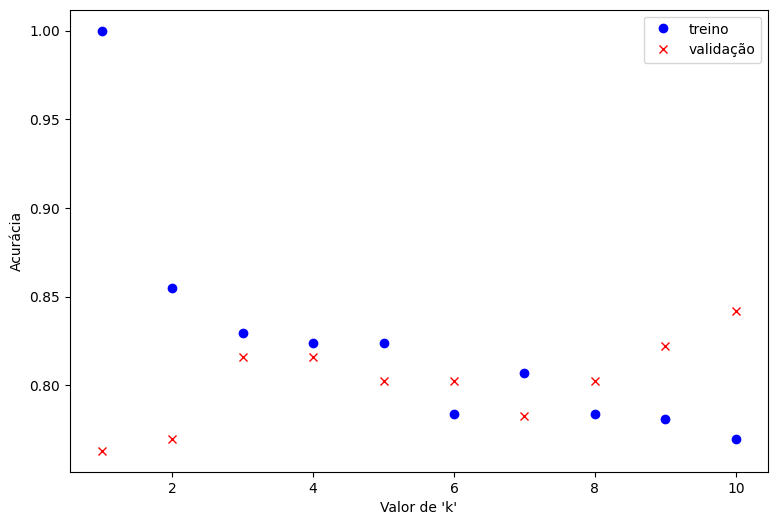

In [16]:
plt.figure(figsize=(9, 6))

plt.plot(k_list, acc_train_list, 'o', color='blue', label='treino')
plt.plot(k_list, acc_val_list, 'x', color='red', label='validação')
plt.xlabel("Valor de 'k'")
plt.ylabel("Acurácia")
plt.legend(loc='best')

plt.show()

In [17]:
print('k \t acc. treino \t acc. val')
print('----------------------------')
for k_, acc_t, acc_v in zip(k_list, acc_train_list, acc_val_list):
    print(f'{k_} \t {acc_t:.4f} \t {acc_v:.4f}')

k_best = k_list[np.argmax(acc_val_list)]
print(f'\nMelhor \'k\': {k_best} ({np.max(acc_val_list):.4f} acc.)')

k 	 acc. treino 	 acc. val
----------------------------
1 	 1.0000 	 0.7632
2 	 0.8551 	 0.7697
3 	 0.8295 	 0.8158
4 	 0.8239 	 0.8158
5 	 0.8239 	 0.8026
6 	 0.7841 	 0.8026
7 	 0.8068 	 0.7829
8 	 0.7841 	 0.8026
9 	 0.7812 	 0.8224
10 	 0.7699 	 0.8421

Melhor 'k': 10 (0.8421 acc.)


### **Avaliação do modelo**

In [18]:
# Acertos
acertos = y_val == pred

print('\n Predição:')
print(pred)
print('\nReal:')
print(y_val)
print('\nAcerto/Erro:')
print(acertos.astype(int))


 Predição:
['bat' 'bone' 'bone' 'apple' 'apple' 'bone' 'bat' 'bone' 'bat' 'apple'
 'apple' 'bat' 'beetle' 'bat' 'bone' 'bone' 'bone' 'bat' 'bat' 'beetle'
 'apple' 'apple' 'bat' 'beetle' 'apple' 'bone' 'apple' 'apple' 'beetle'
 'beetle' 'apple' 'apple' 'apple' 'bone' 'apple' 'beetle' 'bone' 'bat'
 'bat' 'bat' 'apple' 'beetle' 'beetle' 'beetle' 'apple' 'beetle' 'bat'
 'apple' 'beetle' 'apple' 'bat' 'bat' 'beetle' 'bone' 'apple' 'bat'
 'apple' 'apple' 'apple' 'apple' 'bone' 'bat' 'bat' 'bone' 'bone' 'bone'
 'apple' 'apple' 'bone' 'bat' 'beetle' 'bat' 'bone' 'bat' 'bat' 'bat'
 'beetle' 'bat' 'bone' 'bat' 'bat' 'apple' 'beetle' 'apple' 'bat' 'bat'
 'bone' 'bat' 'beetle' 'bat' 'bone' 'apple' 'bat' 'bone' 'bone' 'bat'
 'bone' 'beetle' 'apple' 'apple' 'bone' 'apple' 'apple' 'bat' 'bat'
 'apple' 'beetle' 'apple' 'bone' 'bat' 'beetle' 'apple' 'apple' 'apple'
 'beetle' 'bat' 'bone' 'beetle' 'bat' 'beetle' 'beetle' 'apple' 'bone'
 'bone' 'beetle' 'bone' 'beetle' 'bat' 'bat' 'bat' 'bone' 'bat' 'be

### **Matriz de confusão e o relatório de treinamento (VALIDAÇÃO)**

In [19]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(y_val, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(y_val, pred))

print('\nAcurácia:')
print(f'{(acc_val*100):.4f}%')


Matriz de confusão:
[[37  1  0  0]
 [ 1 32  4  1]
 [ 2  8 26  2]
 [ 0  4  1 33]]

Relatório de classificação:
              precision    recall  f1-score   support

       apple       0.93      0.97      0.95        38
         bat       0.71      0.84      0.77        38
      beetle       0.84      0.68      0.75        38
        bone       0.92      0.87      0.89        38

    accuracy                           0.84       152
   macro avg       0.85      0.84      0.84       152
weighted avg       0.85      0.84      0.84       152


Acurácia:
84.2105%


## **Validação do modelo (conjunto de testes)**

### **Carregando o conjunto de teste**

In [20]:
#ds_path = 'data/mpeg7_4classes_aug_x8_work'

test_path = ds_path + '/Test'

classes_list = os.listdir(test_path)

print(f'Classes: {classes_list}')

test_image_list = []
test_label_list = []
test_filename_list = []

for classe in classes_list:

    filename_list_tmp = os.listdir(os.path.join(test_path, classe))

    for filename in filename_list_tmp:

        img_tmp = plt.imread(os.path.join(test_path, classe, filename))
        img_tmp = transform.resize(img_tmp, (164, 164), anti_aliasing=True)
        test_image_list.append(img_tmp)
        test_label_list.append(classe)
        test_filename_list.append(filename)

# Conversão dos nomes das classes para índices numéricos
_, _, test_label_list_idx = np.unique(test_label_list, return_index=True, return_inverse=True)
print(test_label_list_idx)

Classes: ['apple', 'bat', 'beetle', 'bone']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


### **Extraindo as características do conjunto de testes**

In [21]:
# Realiza a extração de características no conjunto de teste
test_feature_mat = FeatureXtract(test_image_list, test_label_list)

# Converte a lista de caracteristicas para um arranjo NumPy
test_feature_map = np.array(test_feature_mat)

### **Plotando as características normalizadas**

In [22]:
df_norm = pd.DataFrame(test_feature_map, columns=features)

df_norm['class'] = test_label_list
print(df_norm)

        area  area_convex    extent  major_axis  minor_axis  solidity  class
0    12181.0      13144.0  0.717036  127.593503  123.887098  0.926735  apple
1    12111.0      13295.0  0.713503  129.410590  122.752372  0.910944  apple
2    12181.0      13144.0  0.717036  127.593503  123.887098  0.926735  apple
3    12111.0      13295.0  0.713503  129.410590  122.752372  0.910944  apple
4    12181.0      13144.0  0.717036  127.593503  123.887098  0.926735  apple
..       ...          ...       ...         ...         ...       ...    ...
211  44899.0      92320.0  0.417339  246.988611    4.940187  0.486341   bone
212  44608.0      92716.0  0.414634  247.425863    4.933909  0.481125   bone
213  44608.0      92716.0  0.414634  247.425863    4.933909  0.481125   bone
214  43939.0      92172.0  0.408416  245.242674    4.913224  0.476707   bone
215  43939.0      92172.0  0.408416  245.242674    4.913224  0.476707   bone

[216 rows x 7 columns]


In [23]:
# Imprime a matriz de caracteristica
with np.printoptions(precision=4, suppress=True):
    print(test_feature_map)

[[12181.     13144.         0.717    127.5935   123.8871     0.9267]
 [12111.     13295.         0.7135   129.4106   122.7524     0.9109]
 [12181.     13144.         0.717    127.5935   123.8871     0.9267]
 ...
 [44608.     92716.         0.4146   247.4259     4.9339     0.4811]
 [43939.     92172.         0.4084   245.2427     4.9132     0.4767]
 [43939.     92172.         0.4084   245.2427     4.9132     0.4767]]


### **Normalizando as caracteristicas**

In [24]:
X_test = test_feature_map[0:len(test_image_list),:]

# Transformada Normal de Caracteristicas (Sklearn)
scaler = preprocessing.StandardScaler().fit(X_test)
with np.printoptions(precision=4, suppress=True):
    print(f'Média:  \t {np.array(scaler.mean_)}')
    print(f'Desv. pad.: \t {np.array(scaler.scale_)}')

Média:  	 [37453.1204 66335.037      0.5201   190.2527    44.0227     0.6432]
Desv. pad.: 	 [19893.707  38211.4031     0.139     41.3188    55.4474     0.1755]


In [25]:
X_test_norm = scaler.transform(X_test)
print(X_test_norm)

[[-1.27035752 -1.39201999  1.41675134 -1.51648104  1.44036234  1.61544271]
 [-1.27387622 -1.38806829  1.39133912 -1.47250381  1.41989744  1.52547025]
 [-1.27035752 -1.39201999  1.41675134 -1.51648104  1.44036234  1.61544271]
 ...
 [ 0.35965542  0.69039503 -0.75864327  1.38370807 -0.7049703  -0.92356181]
 [ 0.3260267   0.67615845 -0.80337675  1.33087042 -0.70534336 -0.94873801]
 [ 0.3260267   0.67615845 -0.80337675  1.33087042 -0.70534336 -0.94873801]]


### **Nova classificação do modelo utilizando o KNN e o conjunto de testes**

In [26]:
# Classificação utilizando o melhor valor de k (k_best)
clf = neighbors.KNeighborsClassifier(n_neighbors=k_best)

# Treinando o classificador
clf.fit(X_train_norm, y_train)

# Testando o classificador
pred = clf.predict(X_test_norm)
acc_test = metrics.accuracy_score(test_label_list, pred)

### **Matriz de confusão e relatório de classificação (TESTE)**

In [27]:
print('\nMatriz de confusão:')
print(metrics.confusion_matrix(test_label_list, pred))

print('\nRelatório de classificação:')
print(metrics.classification_report(test_label_list, pred))

print('\nAcurácia:')
print(f'{(acc_test*100):.4f}%')


Matriz de confusão:
[[54  0  0  0]
 [12  6 30  6]
 [ 4  0 50  0]
 [ 0  0  0 54]]

Relatório de classificação:
              precision    recall  f1-score   support

       apple       0.77      1.00      0.87        54
         bat       1.00      0.11      0.20        54
      beetle       0.62      0.93      0.75        54
        bone       0.90      1.00      0.95        54

    accuracy                           0.76       216
   macro avg       0.82      0.76      0.69       216
weighted avg       0.82      0.76      0.69       216


Acurácia:
75.9259%
